In [2]:
!ls

config				rcaug_model-8filt-seed5.ipynb
inputs.gz			rcaug_model-seed5.ipynb
labels.gz			rcweights_8filt_model.ipynb
lockdir_runs_perf-metric-auROC	runs_perf-metric-auROC.db
model_files			snapshots
prepSplits.sh			splits
rc				test_data.hdf5
rcaug_model-16filt-seed0.ipynb	train_data.hdf5
rcaug_model-8filt-seed0.ipynb	valid_data.hdf5
rcaug_model-8filt-seed1.ipynb	yaml
rcaug_model-8filt-seed2.ipynb


In [3]:
prefix="K0SFz"; record="71" #rcaug, perf 88.5
#prefix="sKtsW"; record="72" #norcaug
final_model_weights = "model_files/record_"+record+"_model_"+prefix+"_modelWeights.h5"
model_json = "model_files/record_"+record+"_model_"+prefix+"_modelJson.json"

In [4]:
from keras.models import model_from_json
model = model_from_json(open(model_json).read())

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [5]:
import numpy as np

conv_weights_over_epochs = []
conv_biases_over_epochs = []

#track the evolution of filter params
for i in range(30):
    epoch_weights = "snapshots/"+prefix+"/start_epoch"+str(i)+"_model_"+prefix+"_modelWeights.h5"
    model.load_weights(epoch_weights)
    conv_weights, conv_biases = model.layers[0].get_weights()
    conv_weights_over_epochs.append(conv_weights)
    conv_biases_over_epochs.append(conv_biases)

conv_weights_over_epochs = np.squeeze(np.array(conv_weights_over_epochs))
conv_biases_over_epochs = np.array(conv_biases_over_epochs)

#mean norm the weights
#weights have dim [epoch, len, ACGT, chan]
mean_per_epoch_per_pos_per_chan = np.mean(conv_weights_over_epochs,axis=-2)
conv_weights_over_epochs = conv_weights_over_epochs - mean_per_epoch_per_pos_per_chan[:,:,None,:]
conv_biases_over_epochs = conv_biases_over_epochs + np.sum(mean_per_epoch_per_pos_per_chan,axis=1) #essential for cleaning up the biases plot


In [6]:
#compute the total change in weights from epoch to epoch
deltas = np.abs(conv_weights_over_epochs[:-1] - conv_weights_over_epochs[1:])
deltas = np.sum(np.sum(deltas,axis=1),axis=1) #sum up the change over axes that aren't channel axis

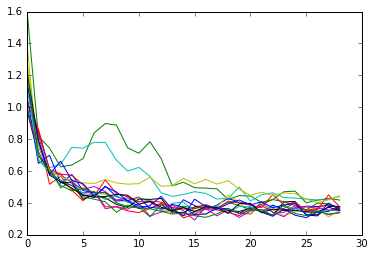

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(deltas.shape[1]):
    plt.plot(deltas[:,i])

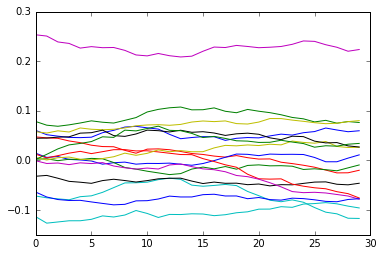

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(conv_biases_over_epochs.shape[1]):
    plt.plot(conv_biases_over_epochs[:,i])

In [9]:
#compute importance scores
from momma_dragonn.data_loaders.hdf5_data_loader import MultimodalAtOnceDataLoader
data_loader = MultimodalAtOnceDataLoader(path_to_hdf5="valid_data.hdf5",
                                         bundle_x_and_y_in_generator=False,
                                         strip_enclosing_dictionary=True)
data = data_loader.get_data()

('Input modes', [u'sequence'])
('Output modes', [u'output'])
('num_to_load_for_eval is ', None, 'but num_items is', 6430, '- fixing')


In [10]:
from keras import backend as K
import theano
score_func = theano.function([model.input, K.learning_phase()],
                             (theano.grad(K.sum(model.layers[-2].output[:,0],axis=0), model.layers[0].output)*model.layers[0].output),
                             allow_input_downcast=True)

In [11]:
from deeplift.util import run_function_in_batches
channel_scores = np.array(run_function_in_batches(score_func, input_data_list=[data.X], learning_phase=False, batch_size=100))

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000


In [12]:
channel_scores_pos = np.array([x for x,y in zip(channel_scores,data.Y) if y==1])
channel_scores_neg = np.array([x for x,y in zip(channel_scores,data.Y) if y==0])

In [13]:
channel_scores_pos = np.mean(np.sum((channel_scores_pos),axis=1),axis=0)
channel_scores_neg = np.mean(np.sum((channel_scores_neg),axis=1),axis=0)
diff = channel_scores_pos - channel_scores_neg

(array([ 10.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.]),
 array([  7.68303871e-04,   6.91178441e-02,   1.37467384e-01,
          2.05816925e-01,   2.74166465e-01,   3.42516005e-01,
          4.10865545e-01,   4.79215086e-01,   5.47564626e-01,
          6.15914166e-01,   6.84263706e-01,   7.52613246e-01,
          8.20962787e-01,   8.89312327e-01,   9.57661867e-01,
          1.02601141e+00,   1.09436095e+00]),
 <a list of 16 Patch objects>)

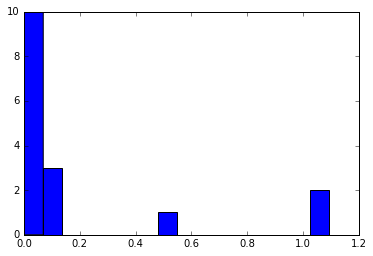

In [14]:
import matplotlib.pyplot as plt
plt.hist(diff,bins=len(diff))

In [15]:
#sort the channels by their scores
sorted_channels = sorted(enumerate(diff),key=lambda x: -x[1])

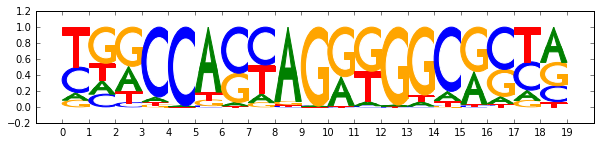

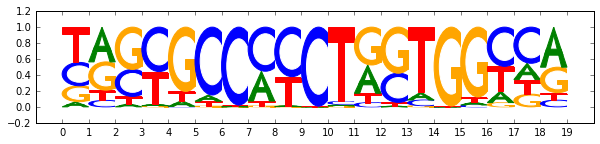

In [27]:
from simdna import synthetic
import simdna
from deeplift.visualization import viz_sequence

loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
viz_sequence.plot_weights(loadedMotifs.getPwm("CTCF_known1").getRows(), figsize=(10,2))
viz_sequence.plot_weights(loadedMotifs.getPwm("CTCF_known1").getRows()[::-1,::-1], figsize=(10,2))

('channel', 3, 'score:', 1.0943609)
('bias:', -0.11703484)


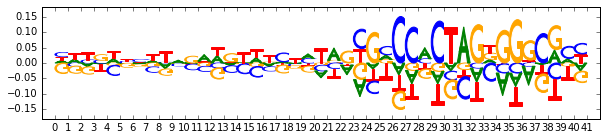

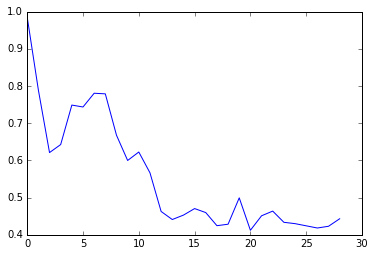

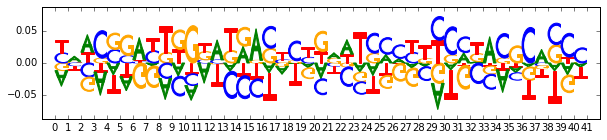

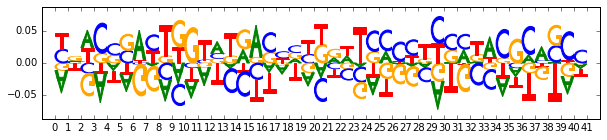

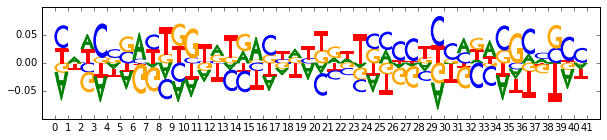

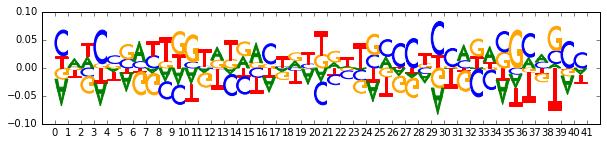

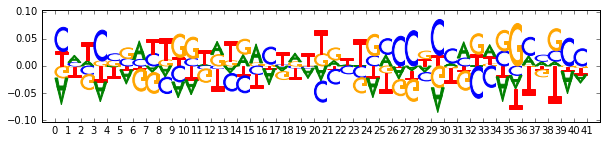

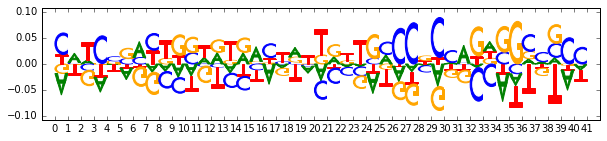

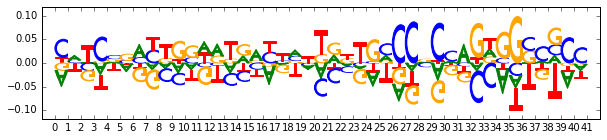

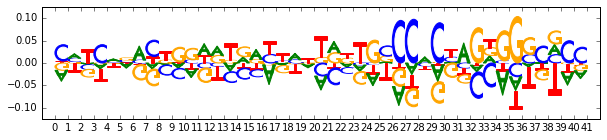

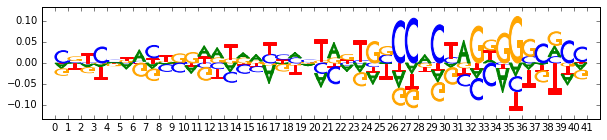

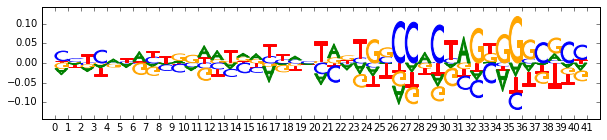

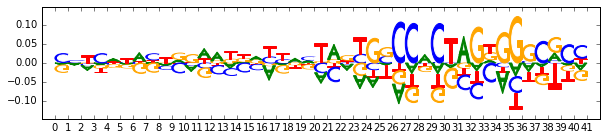

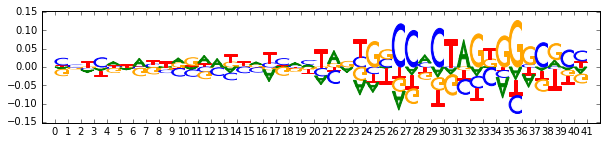

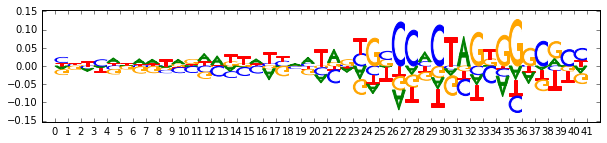

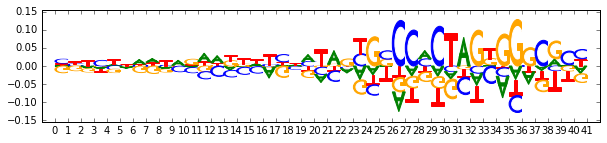

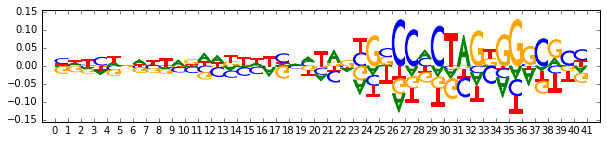

('channel', 1, 'score:', 1.0935977)
('bias:', 0.076413095)


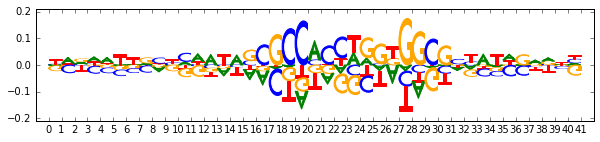

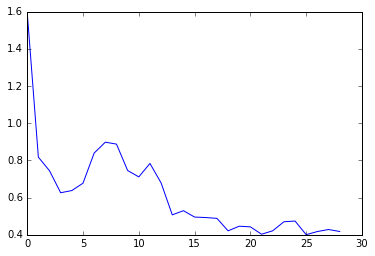

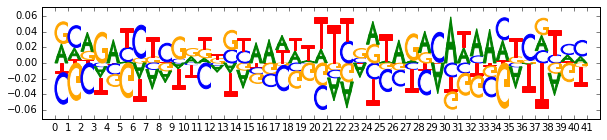

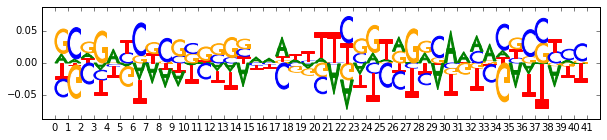

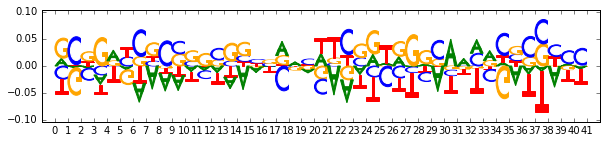

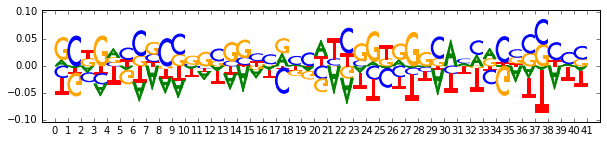

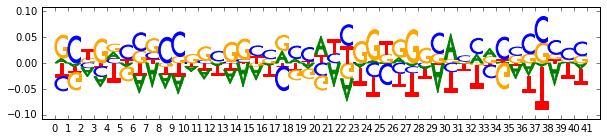

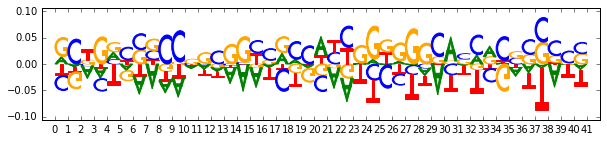

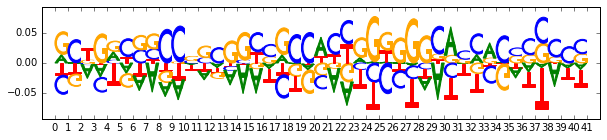

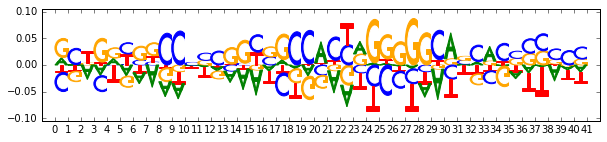

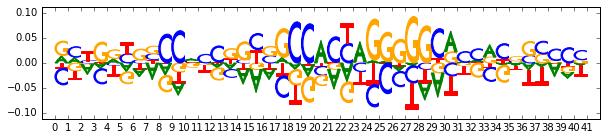

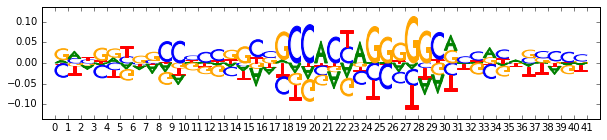

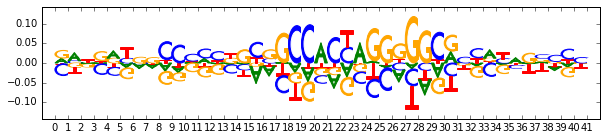

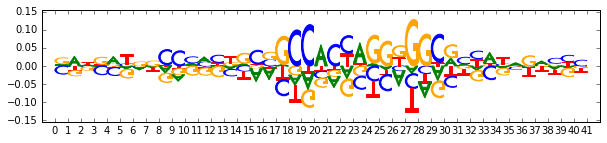

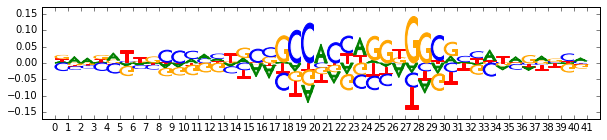

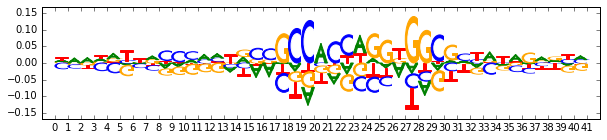

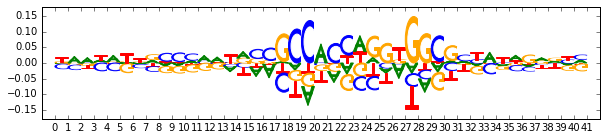

('channel', 12, 'score:', 0.52537334)
('bias:', 0.026436104)


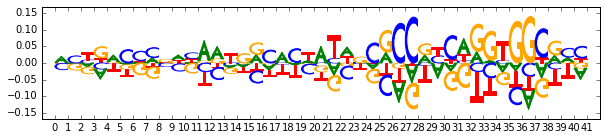

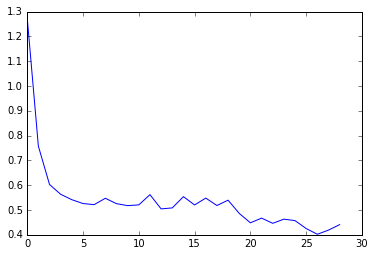

('channel', 9, 'score:', 0.12815964)
('bias:', -0.07578472)


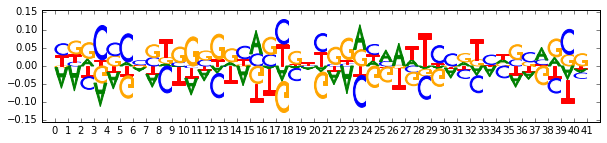

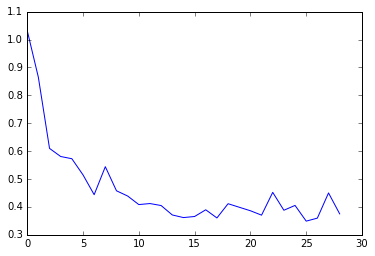

('channel', 5, 'score:', 0.11668706)
('bias:', 0.080219254)


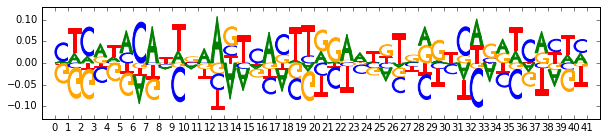

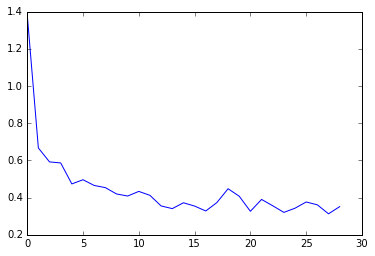

('channel', 13, 'score:', 0.072916865)
('bias:', 0.02699445)


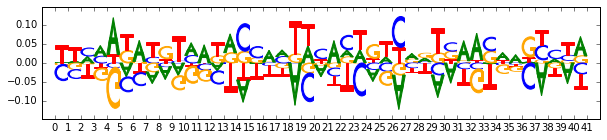

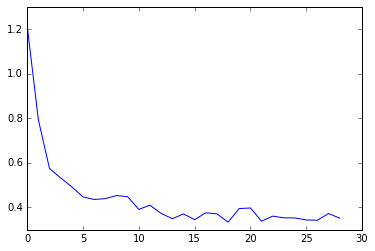

('channel', 4, 'score:', 0.059621811)
('bias:', 0.22353975)


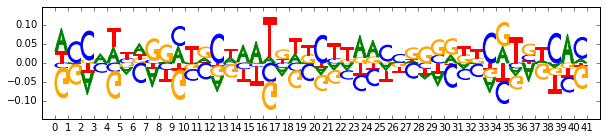

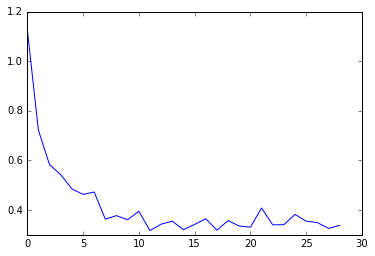

('channel', 15, 'score:', 0.058592558)
('bias:', 0.034262478)


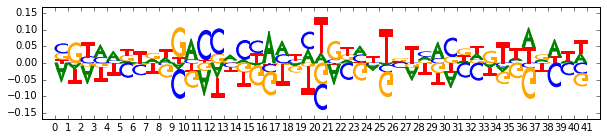

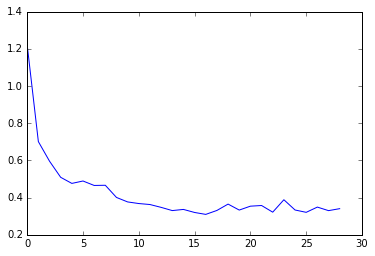

('channel', 8, 'score:', 0.047577992)
('bias:', -0.0091776699)


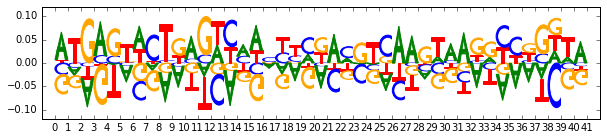

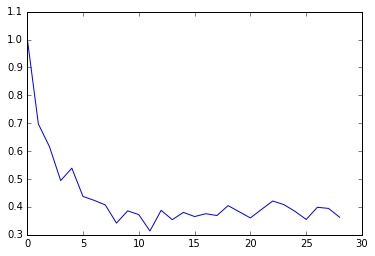

('channel', 2, 'score:', 0.033241987)
('bias:', -0.01988034)


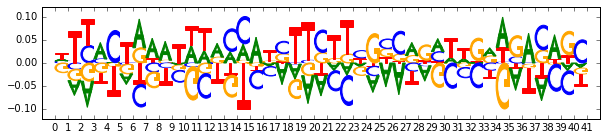

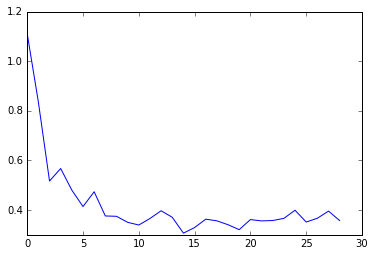

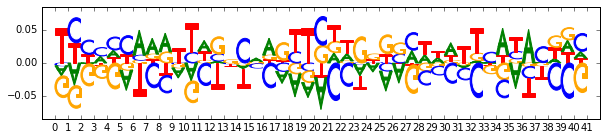

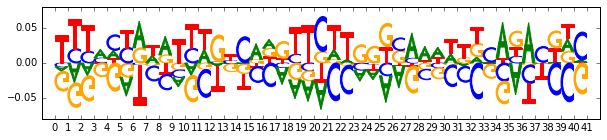

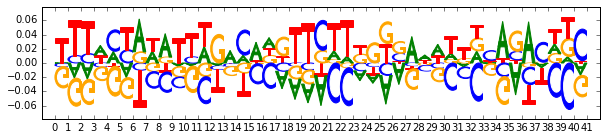

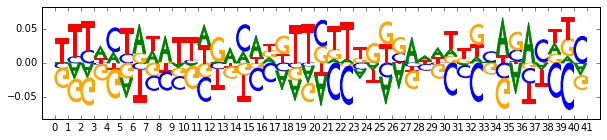

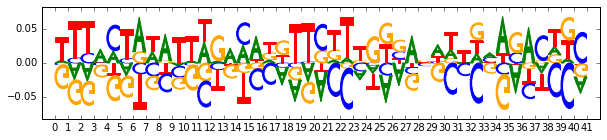

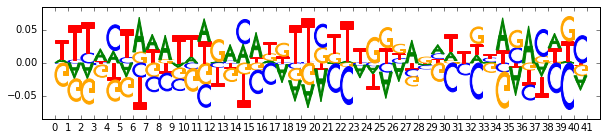

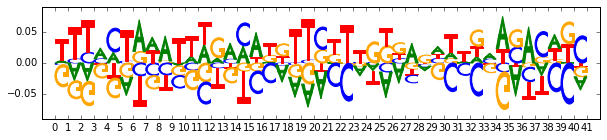

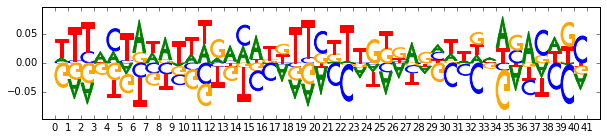

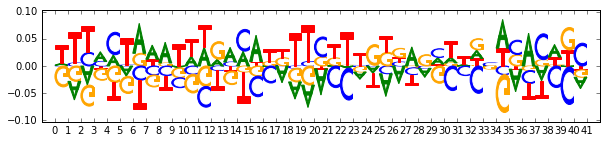

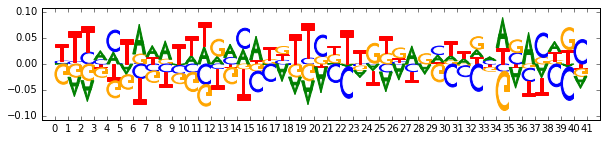

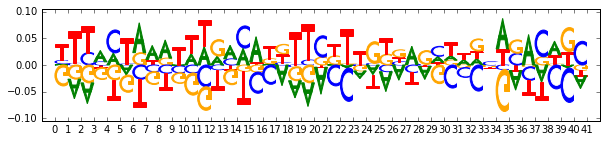

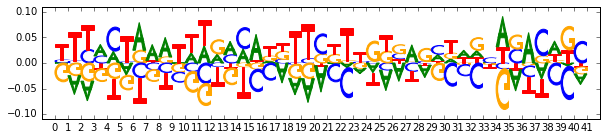

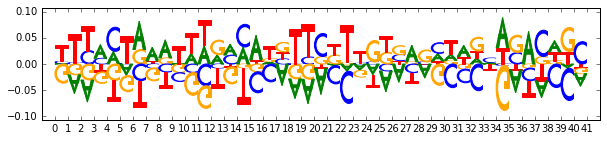

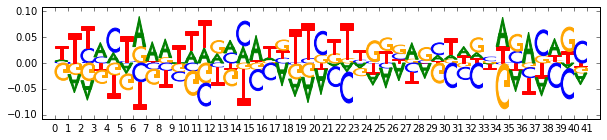

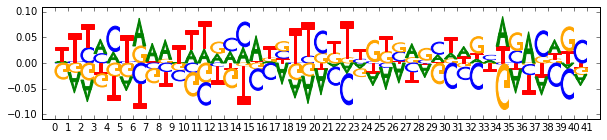

('channel', 7, 'score:', 0.031058908)
('bias:', 0.01114093)


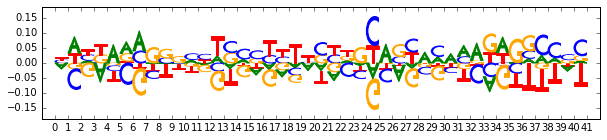

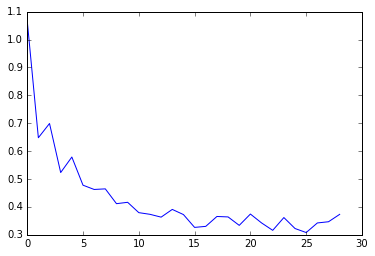

('channel', 14, 'score:', 0.020606577)
('bias:', -0.077235751)


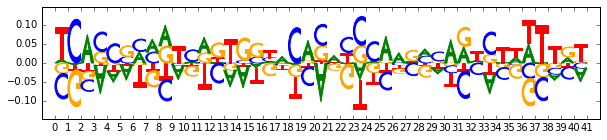

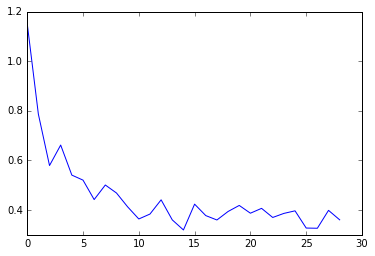

('channel', 6, 'score:', 0.013017595)
('bias:', -0.046057228)


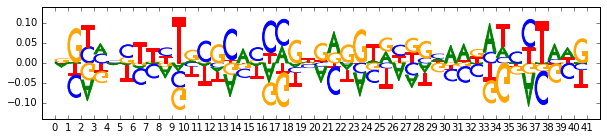

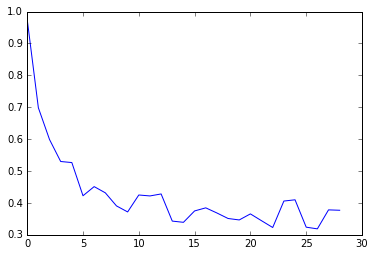

('channel', 0, 'score:', 0.012247384)
('bias:', 0.059765663)


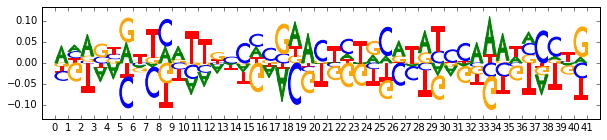

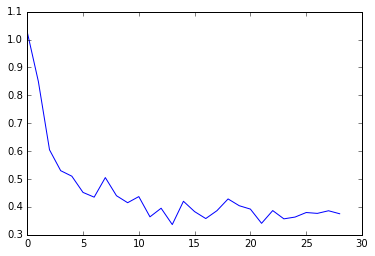

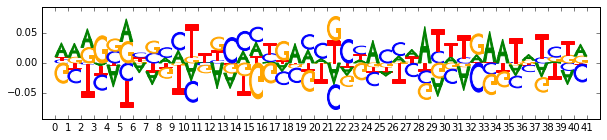

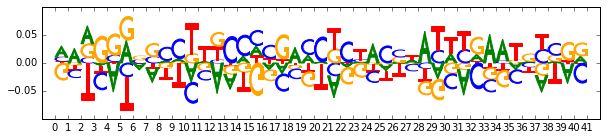

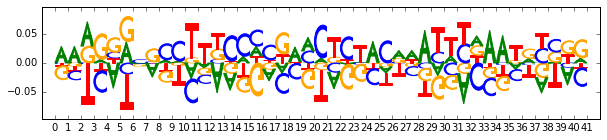

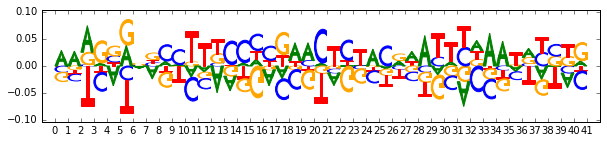

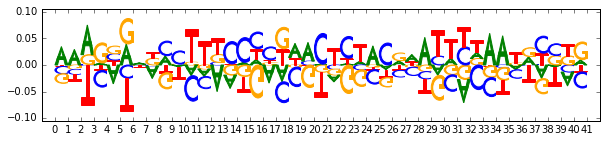

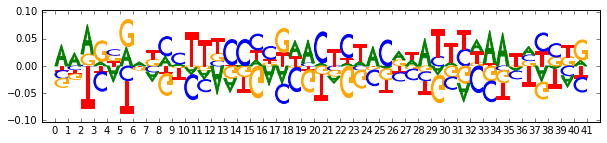

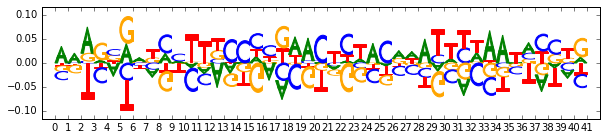

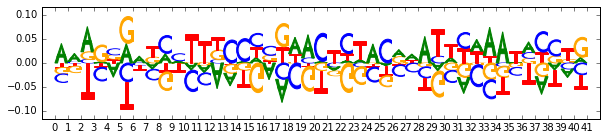

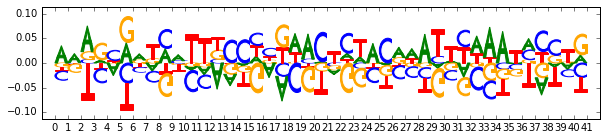

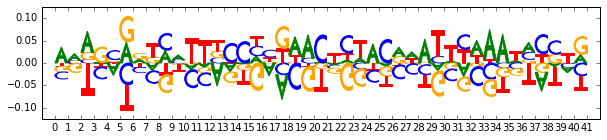

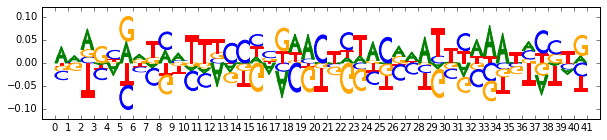

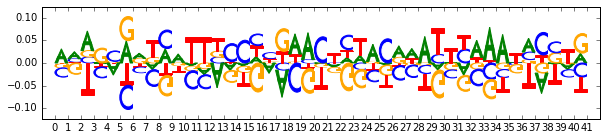

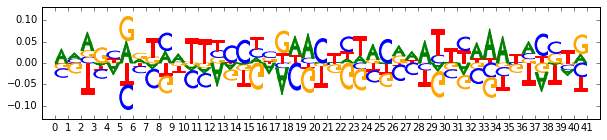

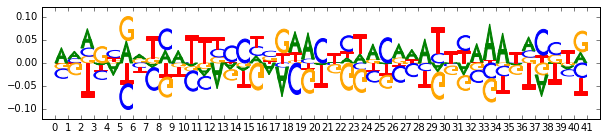

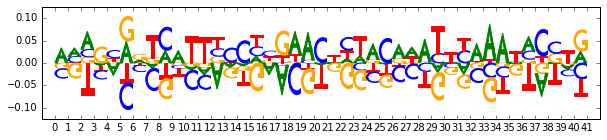

('channel', 10, 'score:', 0.01031103)
('bias:', -0.09587685)


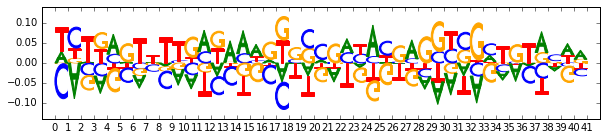

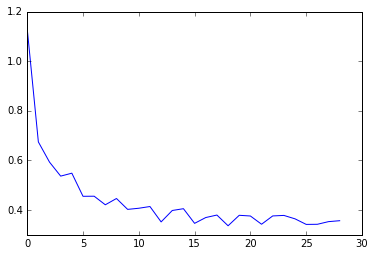

('channel', 11, 'score:', 0.00076830387)
('bias:', -0.078253195)


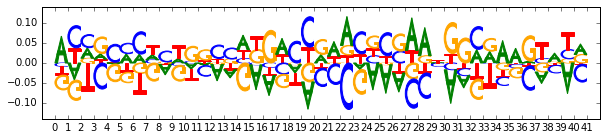

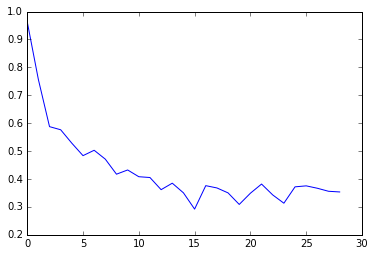

In [29]:
from deeplift.visualization import viz_sequence
for (i, channel_score) in sorted_channels[:16]:
    print("channel",i,"score:",channel_score)
    final_weights = conv_weights_over_epochs[-1,:,:,i]
    final_bias = conv_biases_over_epochs[-1,i]
    print("bias:",final_bias)
    viz_sequence.plot_weights(final_weights[::-1,:], figsize=(10,2)) #convolution so rev length dim but not channel
    plt.plot(deltas[:,i])
    plt.show()
    if (i < 4):
        for epoch in range(15):
            viz_sequence.plot_weights(conv_weights_over_epochs[epoch,::-1,:,i], figsize=(10,2))
    

In [69]:
conv_weights_over_epochs.shape

(80, 41, 1, 4, 16)